# Notebook 2 : Video Processing and Frame Extraction


## Introduction


In this notebook, we will explore how to process videos, extract frames, and perform specific operations on the frames using Python and OpenCV. We will use the ffmpeg library to handle video processing tasks and TensorFlow for frame manipulation and preprocessing. The goal is to extract frames from a video dataset, apply transformations if necessary, and save them as individual image files for further analysis or training deep learning models.



##1. System Setup


In [ ]:
import sys
import tensorflow as tf

print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Tensorflow version: 2.12.0


In [ ]:
!pip uninstall ffmpeg-python
!pip install ffmpeg-python
!pip install imutils

**Import libraries**

In [ ]:
import ffmpeg
import functools
import os
import cv2
import tqdm
import numpy as np

##2. Mounting Google Drive

In [ ]:
# mouting google drive
from google.colab import drive
drive.mount('/content/drive')
# testing
%cd /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset
%ls

Mounted at /content/drive
/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset
bad_back_round/  bad_head/         bad_shallow/  good/
bad_back_warp/   bad_inner_thigh/  bad_toe/


##3. Data preparation

### Define paths to the dataset

In [ ]:
# Define Path to the Dataset folder
BASE_PATH = '/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset'
VIDEOS_PATH = os.path.join(BASE_PATH,'**','*.mp4')
VIDEO_PATHS = tf.io.gfile.glob(VIDEOS_PATH)
print(VIDEOS_PATH)

# LSTM sequence length and batch_size
SEQUENCE_LENGTH = 40
BATCH_SIZE = 16

# Efficientnet B4(380)architecture
IMG_SIZE = 380

/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/**/*.mp4


## 4. Data augmentation

In [ ]:
SUB_FOLDER = ['good', 'bad_inner_thigh', 'bad_toe', 'bad_shallow', 'bad_back_round', 'bad_back_warp', 'bad_head']

for item in SUB_FOLDER:
    sub_path = os.path.join(BASE_PATH, item)
    print(sub_path)
    for video in os.listdir(sub_path):
        suffixes = ('.mp4', '.MP4')
        if video.endswith(suffixes):
            input_path = os.path.join(sub_path, video)

            # Check if the video already starts with "flip"
            if video.startswith("flip"):
                print(f"Skipping video: {video} (already flipped)")
                continue

            flip_file_name = "flip_" + video
            flip_file_path = os.path.join(sub_path, flip_file_name)

            if os.path.exists(flip_file_path):
                print(f"Flip file already exists for video: {video}")
            else:
                out_path = os.path.join(sub_path, flip_file_name)
                os.system(f"ffmpeg -i {input_path} -vf hflip {out_path}")
                print(f"Flip file created for video: {video}")


/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good
Flip file already exists for video: 0918_squat_000001.mp4
Flip file already exists for video: 0918_squat_000003.mp4
Flip file already exists for video: 0918_squat_000004.mp4
Flip file already exists for video: 0918_squat_000007.mp4
Flip file already exists for video: 0918_squat_000005.mp4
Flip file already exists for video: 0918_squat_000009.mp4
Flip file already exists for video: 0918_squat_000006.mp4
Flip file already exists for video: 0918_squat_000045.mp4
Flip file already exists for video: 0918_squat_000047.mp4
Flip file already exists for video: 0918_squat_000044.mp4
Flip file already exists for video: 0918_squat_000046.mp4
Flip file already exists for video: 0918_squat_000049.mp4
Flip file already exists for video: 0922_squat_000006.mp4
Flip file already exists for video: 0922_squat_000004.mp4
Flip file already exists for video: 0922_squat_000007.mp4
Flip file already exists for video: 0918_squat_000050.mp4
Flip f

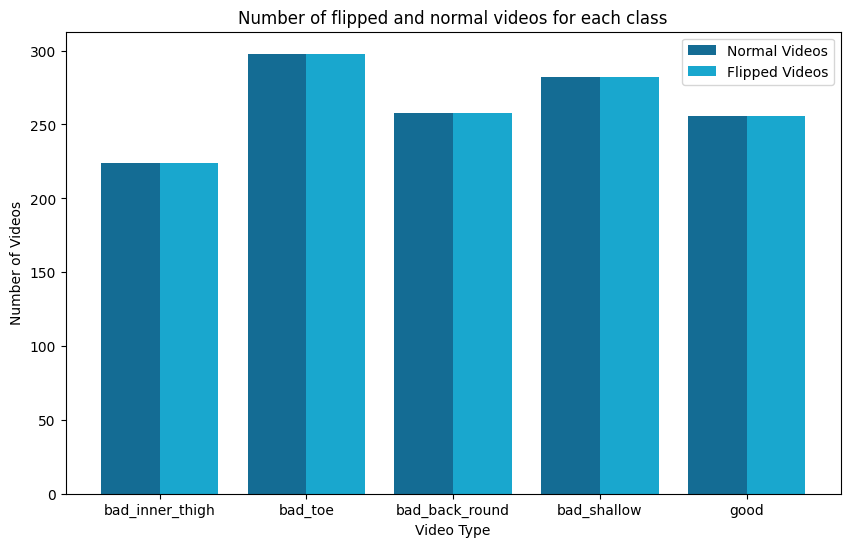

## 4. Data pre-processing

### Efficientnet pre-processing
function to process each frame before passing it to the feature extraction model

In [ ]:
# Following the  Efficientnet B4(380) architecture
IMG_SIZE = 380

### Video frame sampling

In [ ]:
import cv2
import tensorflow as tf
import os
import numpy as np

# Processing raw images (rotate if needed and resize to match with model)
def process_raw_image(frame):
    # OpenCV reads videos in BGR format, so we need to rearrange the channels to RGB, resize, and preprocess for the CNN
    frame = frame[:, :, ::-1]
    img = tf.image.resize(frame, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def frame_generator():
    for video_path in VIDEO_PATHS:
        frames = []
        cap = cv2.VideoCapture(video_path)

        # Counting number of frames
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        num_frames = int(frame_rate * 4)  # Extract frames for the first 4 seconds

        # Generate equally spaced frame indices
        frame_indices = np.linspace(0, num_frames - 1, num=40, dtype=int)

        # Create folder to store generated images
        img_folder_name = video_path.replace('.mp4', '_folder380')

        # If folder does not exist, create a new one; otherwise, skip
        if not os.path.isdir(img_folder_name):
            print(f"Directory {img_folder_name} does not exist")
            os.mkdir(img_folder_name)
        else:
            print(f"Video already processed: {img_folder_name}")
            continue

        current_frame = 0
        img_no = 1

        while current_frame < num_frames and img_no <= 40:
            success, frame = cap.read()

            if not success:
                break

            if current_frame in frame_indices:
                img = process_raw_image(frame)
                if img is not None:
                    img_name = os.path.join(img_folder_name, f'img{img_no}.jpg')
                    tf.keras.preprocessing.image.save_img(img_name, img)
                    img_no += 1

            current_frame += 1

        cap.release()

        if img_no > 1:
            yield img, video_path


In [ ]:
# Load Dataset
dataset = tf.data.Dataset.from_generator(frame_generator,
                                          output_types=(tf.float32,tf.string),
                                          output_shapes=((IMG_SIZE,IMG_SIZE,3),()))

# set batch_size
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Print shape and type of dataset
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


##4. Video Processing and Frame Extraction

In this section, we will iterate over each video file in the dataset and perform the following steps:


*   Load the video using OpenCV's VideoCapture.
*   Determine the frame rate and calculate the number of frames to extract.
Sample frames evenly from the video based on the desired sequence length.
Process each frame by resizing it and converting it to the appropriate format.
Save the processed frame as an image file in the designated folder.

**Build Feature Extraction Model**

In [ ]:
# weights (imagenet or student-noise) https://github.com/qubvel/efficientnet
efficientnet_b4 = tf.keras.applications.EfficientNetB4(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                                              include_top=False,
                                                              weights='imagenet')
x = efficientnet_b4.output
print(x)
# Average Pooling - transforming the feature map from 12*12*1792 to 1x1792 feature vector
pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extraction_model = tf.keras.Model(efficientnet_b4.input,pooling_output)
print(feature_extraction_model.input)


KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 1792), dtype=tf.float32, name=None), name='top_activation/IdentityN:0', description="created by layer 'top_activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
feature_extraction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 380, 380, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 380, 380, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
import tqdm
import tensorflow as tf
import numpy as np

# Initialize current_path and all_features outside the loop
current_path = None
all_features = []

# Loop over the dataset
for img, batch_path in tqdm.tqdm(dataset):
    # Extract features and reshape batch_features
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    for features, path in zip(batch_features.numpy(), batch_path.numpy()):
        if current_path is not None and path != current_path:
            output_path = current_path.decode().replace('.mp4', '.npy')
            np.save(output_path, all_features)
            all_features = []

        current_path = path
        all_features.append(features)

# Save the features of the last video outside the loop
if current_path is not None:
    output_path = current_path.decode().replace('.mp4', '.npy')
    np.save(output_path, all_features)


0it [00:00, ?it/s]

Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1022_squat_000248_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1022_squat_000244_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1022_squat_000245_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1022_squat_000246_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1025_squat_000047_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1025_squat_000042_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_inner_thigh/flip_1025_squat_000048_folder380
Video already processed: /content/drive/Othercomputers/

1it [02:10, 130.60s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000047_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000140_f

2it [03:19, 94.27s/it] 

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000042_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1009_squat_000148_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000044_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000043_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000141_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000143_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000046_f

3it [04:30, 83.83s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000145_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000241_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000242_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000240_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000245_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000244_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000243_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1015_squat_000246_f

4it [05:37, 76.98s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000031_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000034_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000033_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000040_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000135_f

5it [06:34, 69.73s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000237_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000238_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000236_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000239_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1018_squat_000240_f

6it [07:41, 69.00s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000136_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000138_f

7it [08:44, 66.81s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000035_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000034_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000036_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000240_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1022_squat_000239_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000033_f

8it [09:49, 66.43s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000233_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000235_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000236_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1025_squat_000238_f

9it [11:01, 68.23s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000017_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000018_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000020_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000016_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000122_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000118_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000119_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1029_squat_000121_f

10it [12:00, 65.35s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000132_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000039_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000136_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1031_squat_000137_f

11it [13:05, 65.14s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000132_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000042_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000039_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000041_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1103_squat_000135_f

12it [13:45, 57.47s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000045_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000046_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000043_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000144_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000143_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1106_squat_000145_f

13it [14:48, 59.05s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000046_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000044_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000141_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000047_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000145_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/1108_squat_000146_f

14it [15:47, 59.19s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/bad_squat_squat_000027_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/bad_squat_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/bad_squat_squat_000033_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0918_squat_000012_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0918_squat_000011_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0918_squat_000010_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0918_squat_000053_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

15it [16:55, 61.67s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000009_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0918_squat_000056_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000011_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000012_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000067_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000066_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000014_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

16it [17:44, 58.14s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000071_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000108_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000111_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000112_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000113_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000110_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000165_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

17it [18:47, 59.48s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000020_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000019_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0922_squat_000171_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000022_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000021_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000121_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000023_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

18it [19:59, 63.29s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000125_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0928_squat_000010_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0926_squat_000127_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0928_squat_000014_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0928_squat_000016_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0928_squat_000013_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_0928_squat_000012_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

19it [20:59, 62.11s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000033_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000034_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000042_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000044_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000041_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000036_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

20it [21:54, 60.21s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000048_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000047_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

21it [23:00, 61.74s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000147_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000042_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1009_squat_000148_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000044_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000043_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000141_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

22it [23:59, 61.07s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000241_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000242_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000240_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000245_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000244_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000243_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1015_squat_000246_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

23it [25:04, 62.35s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000031_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000034_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000033_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000040_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

24it [25:58, 59.79s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000237_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000238_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000236_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1018_squat_000239_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

25it [27:04, 61.48s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000136_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

26it [28:06, 61.66s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000035_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000034_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000036_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000240_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1022_squat_000239_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

27it [29:10, 62.47s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000139_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000233_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000234_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000235_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1025_squat_000236_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

28it [30:19, 64.41s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000017_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000018_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000020_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000016_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000122_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000118_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1029_squat_000119_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

29it [31:17, 62.45s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000133_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000132_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000038_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000039_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000136_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1031_squat_000135_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

30it [32:21, 62.90s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1103_squat_000132_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1103_squat_000137_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000042_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1103_squat_000134_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1103_squat_000138_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1103_squat_000039_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000041_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

31it [33:02, 56.28s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000046_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000043_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000144_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000143_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1106_squat_000145_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

32it [34:00, 56.72s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000046_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000044_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000140_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000141_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000142_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000047_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_1108_squat_000145_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Datase

33it [34:59, 57.49s/it]

Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_bad_squat_squat_000027_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_bad_squat_squat_000032_folder380 does not exist
Directory /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/bad_back_warp/flip_bad_squat_squat_000033_folder380 does not exist
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_000001_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_000003_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_000004_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_000007_folder380
Video already processed: /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_000005_f

34it [38:54, 68.67s/it] 


In [ ]:
import numpy as np

# Load .npy file
data = np.load('/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/good/0918_squat_00001.npy')

# Access the loaded data
print(data.shape)


FileNotFoundError: ignored

## Conclusion
In this notebook, we have learned how to process videos, extract frames, and apply various operations on the frames using Python and OpenCV. We have used ffmpeg for video processing tasks and TensorFlow for frame manipulation and preprocessing. By extracting frames from videos, we can perform further analysis, train deep learning models, or use them for various computer vision tasks. This workflow can be easily customized and extended to suit different video processing requirements.

## Additional functions for creating visuals

In [ ]:
pip install opencv-python


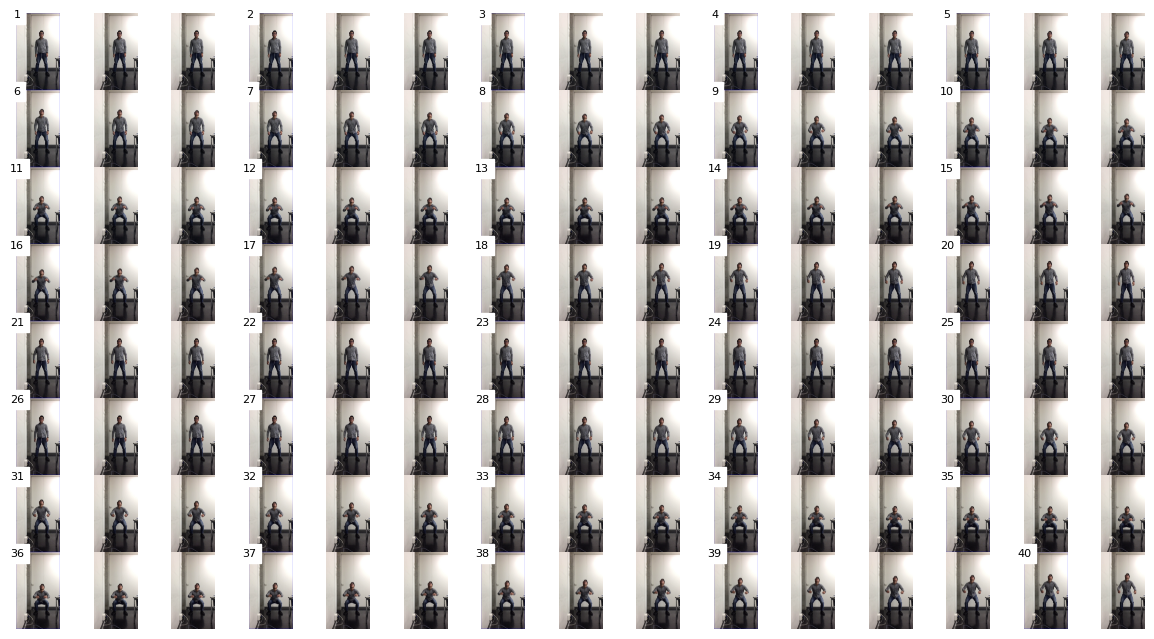

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def create_highlighted_frames_collage(video_path, num_selected_frames=40):
    if not os.path.exists(video_path):
        print("Video file not found.")
        return

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(frame_rate * 4)  # Total frames in the first 4 seconds

    # Create a grid for the collage
    num_rows = 8
    num_cols = int(np.ceil(total_frames / num_rows))
    gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1] * num_cols, height_ratios=[1] * num_rows)

    # Display the collage
    plt.figure(figsize=(num_cols, num_rows))
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between subplots

    current_frame = 0
    selected_frame_indices = np.linspace(0, total_frames - 1, num=num_selected_frames, dtype=int)
    highlighted_frame_count = 1

    for i in range(num_rows):
        for j in range(num_cols):
            success, frame = cap.read()

            if not success:
                break

            is_selected = current_frame in selected_frame_indices

            plt.subplot(gs[i, j])

            if is_selected:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.copyMakeBorder(frame, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(0, 0, 255))  # Add blue border
                plt.text(10, 20, str(highlighted_frame_count), color='black', backgroundcolor='white', fontsize=8, ha='center', va='center')
                highlighted_frame_count += 1
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            plt.imshow(frame)
            plt.axis('off')

            current_frame += 1

    plt.savefig('highlighted_frames_collage.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

# Usage
video_path = '/content/flip_1025_squat_000055.mp4'
create_highlighted_frames_collage(video_path)
